## Chen windows with z-scores, enhancer overlaps, exon overlaps, and replication-timing scores

In [1]:
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'
filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/chen-mchale-enhancer-exon-replicationTiming.bed'
# filename = '/Users/petermchale/Desktop/chen-mchale-enhancer-exon-replicationTiming.bed'

import pandas as pd 

pd.set_option('display.max_columns', 30)

chen_mchale_enhancer_exon_replicationTiming = pd.read_csv(filename, sep='\t')
chen_mchale_enhancer_exon_replicationTiming

chromosome      start        end   position     N_bar  N_observed  \
0             chr1    1432000    1433000    1432500 -0.302927         259   
1             chr1    1450000    1451000    1450500  2.604670         312   
2             chr1    1501000    1502000    1501500  5.954858         320   
3             chr1    1503000    1504000    1503500  3.183047         304   
4             chr1    1507000    1508000    1507500  1.600825         236   
...            ...        ...        ...        ...       ...         ...   
1170064       chr9  137249000  137250000  137249500  2.033871         265   
1170065       chr9  137262000  137263000  137262500  4.529261         302   
1170066       chr9  137269000  137270000  137269500 -2.991450         209   
1170067       chr9  137282000  137283000  137282500 -1.537782         210   
1170068       chr9  137290000  137291000  137290500 -0.097785         223   

            K_bar  K_observed    M  chen zscore  enhancer overlap  \
0       -1.954207         109  256     2.384293            1000.0   
1       -3.416013         109  307    -5.461776               NaN   
2       -1.065578         142  320    -9.097270             199.0   
3       -1.224751         135  304    -4.226767               NaN   
4       -1.789779         105  236    -2.620718               NaN   
...           ...         ...  ...          ...               ...   
1170064 -0.919699         122  261    -5.027486               NaN   
1170065 -0.512921         144  302    -5.979424             346.0   
1170066 -0.785837         104  209    -2.101905            1000.0   
1170067 -0.333503         108  210    -1.325061             572.0   
1170068 -1.182283         106  223     2.257853               NaN   

         merged_exon overlap  window overlaps enhancer  \
0                        NaN                      True   
1                      758.0                     False   
2                        NaN                      True   
3                      411.0                     False   
4                        NaN                     False   
...                      ...                       ...   
1170064                  NaN                     False   
1170065                  NaN                      True   
1170066                  NaN                      True   
1170067                641.0                      True   
1170068                  NaN                     False   

         window overlaps merged_exon window overlaps (enhancer, merged_exon)  \
0                              False                           (True, False)   
1                               True                           (False, True)   
2                              False                           (True, False)   
3                               True                           (False, True)   
4                              False                          (False, False)   
...                              ...                                     ...   
1170064                        False                          (False, False)   
1170065                        False                           (True, False)   
1170066                        False                           (True, False)   
1170067                         True                            (True, True)   
1170068                        False                          (False, False)   

         negative chen zscore  singleton proportion  \
0                   -2.384293              0.425781   
1                    5.461776              0.355049   
2                    9.097270              0.443750   
3                    4.226767              0.444079   
4                    2.620718              0.444915   
...                       ...                   ...   
1170064              5.027486              0.467433   
1170065              5.979424              0.476821   
1170066              2.101905              0.497608   
1170067              1.325061              0.5

In [2]:
import ast

# convert the string '(True, False)', say, to the tuple (True, False)
chen_mchale_enhancer_exon_replicationTiming['window overlaps (enhancer, merged_exon)'] = (
    chen_mchale_enhancer_exon_replicationTiming['window overlaps (enhancer, merged_exon)']
    .apply(ast.literal_eval)
)

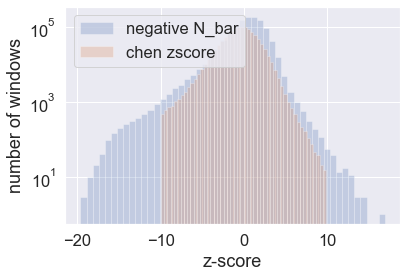

In [3]:
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set(font_scale=1.5)        

plt.hist(
    chen_mchale_enhancer_exon_replicationTiming['negative N_bar'], 
    alpha = 0.25, 
    bins = 50, 
    log = True, 
    label = 'negative N_bar'
)
plt.hist(
    chen_mchale_enhancer_exon_replicationTiming['chen zscore'], 
    alpha = 0.25, 
    bins = 50, 
    log = True, 
    label = 'chen zscore'
)
plt.xlabel('z-score')
plt.ylabel('number of windows')
plt.legend()

## Review: McHale model complements Chen model in predicting enhancers

Consider windows that (i) score in the top quantile of `negative N_bar` or `chen zscore`, and (ii) overlap an enhancer. 
This yields two sets of windows (see image below), which, it turns out, are largely non-overlapping. 

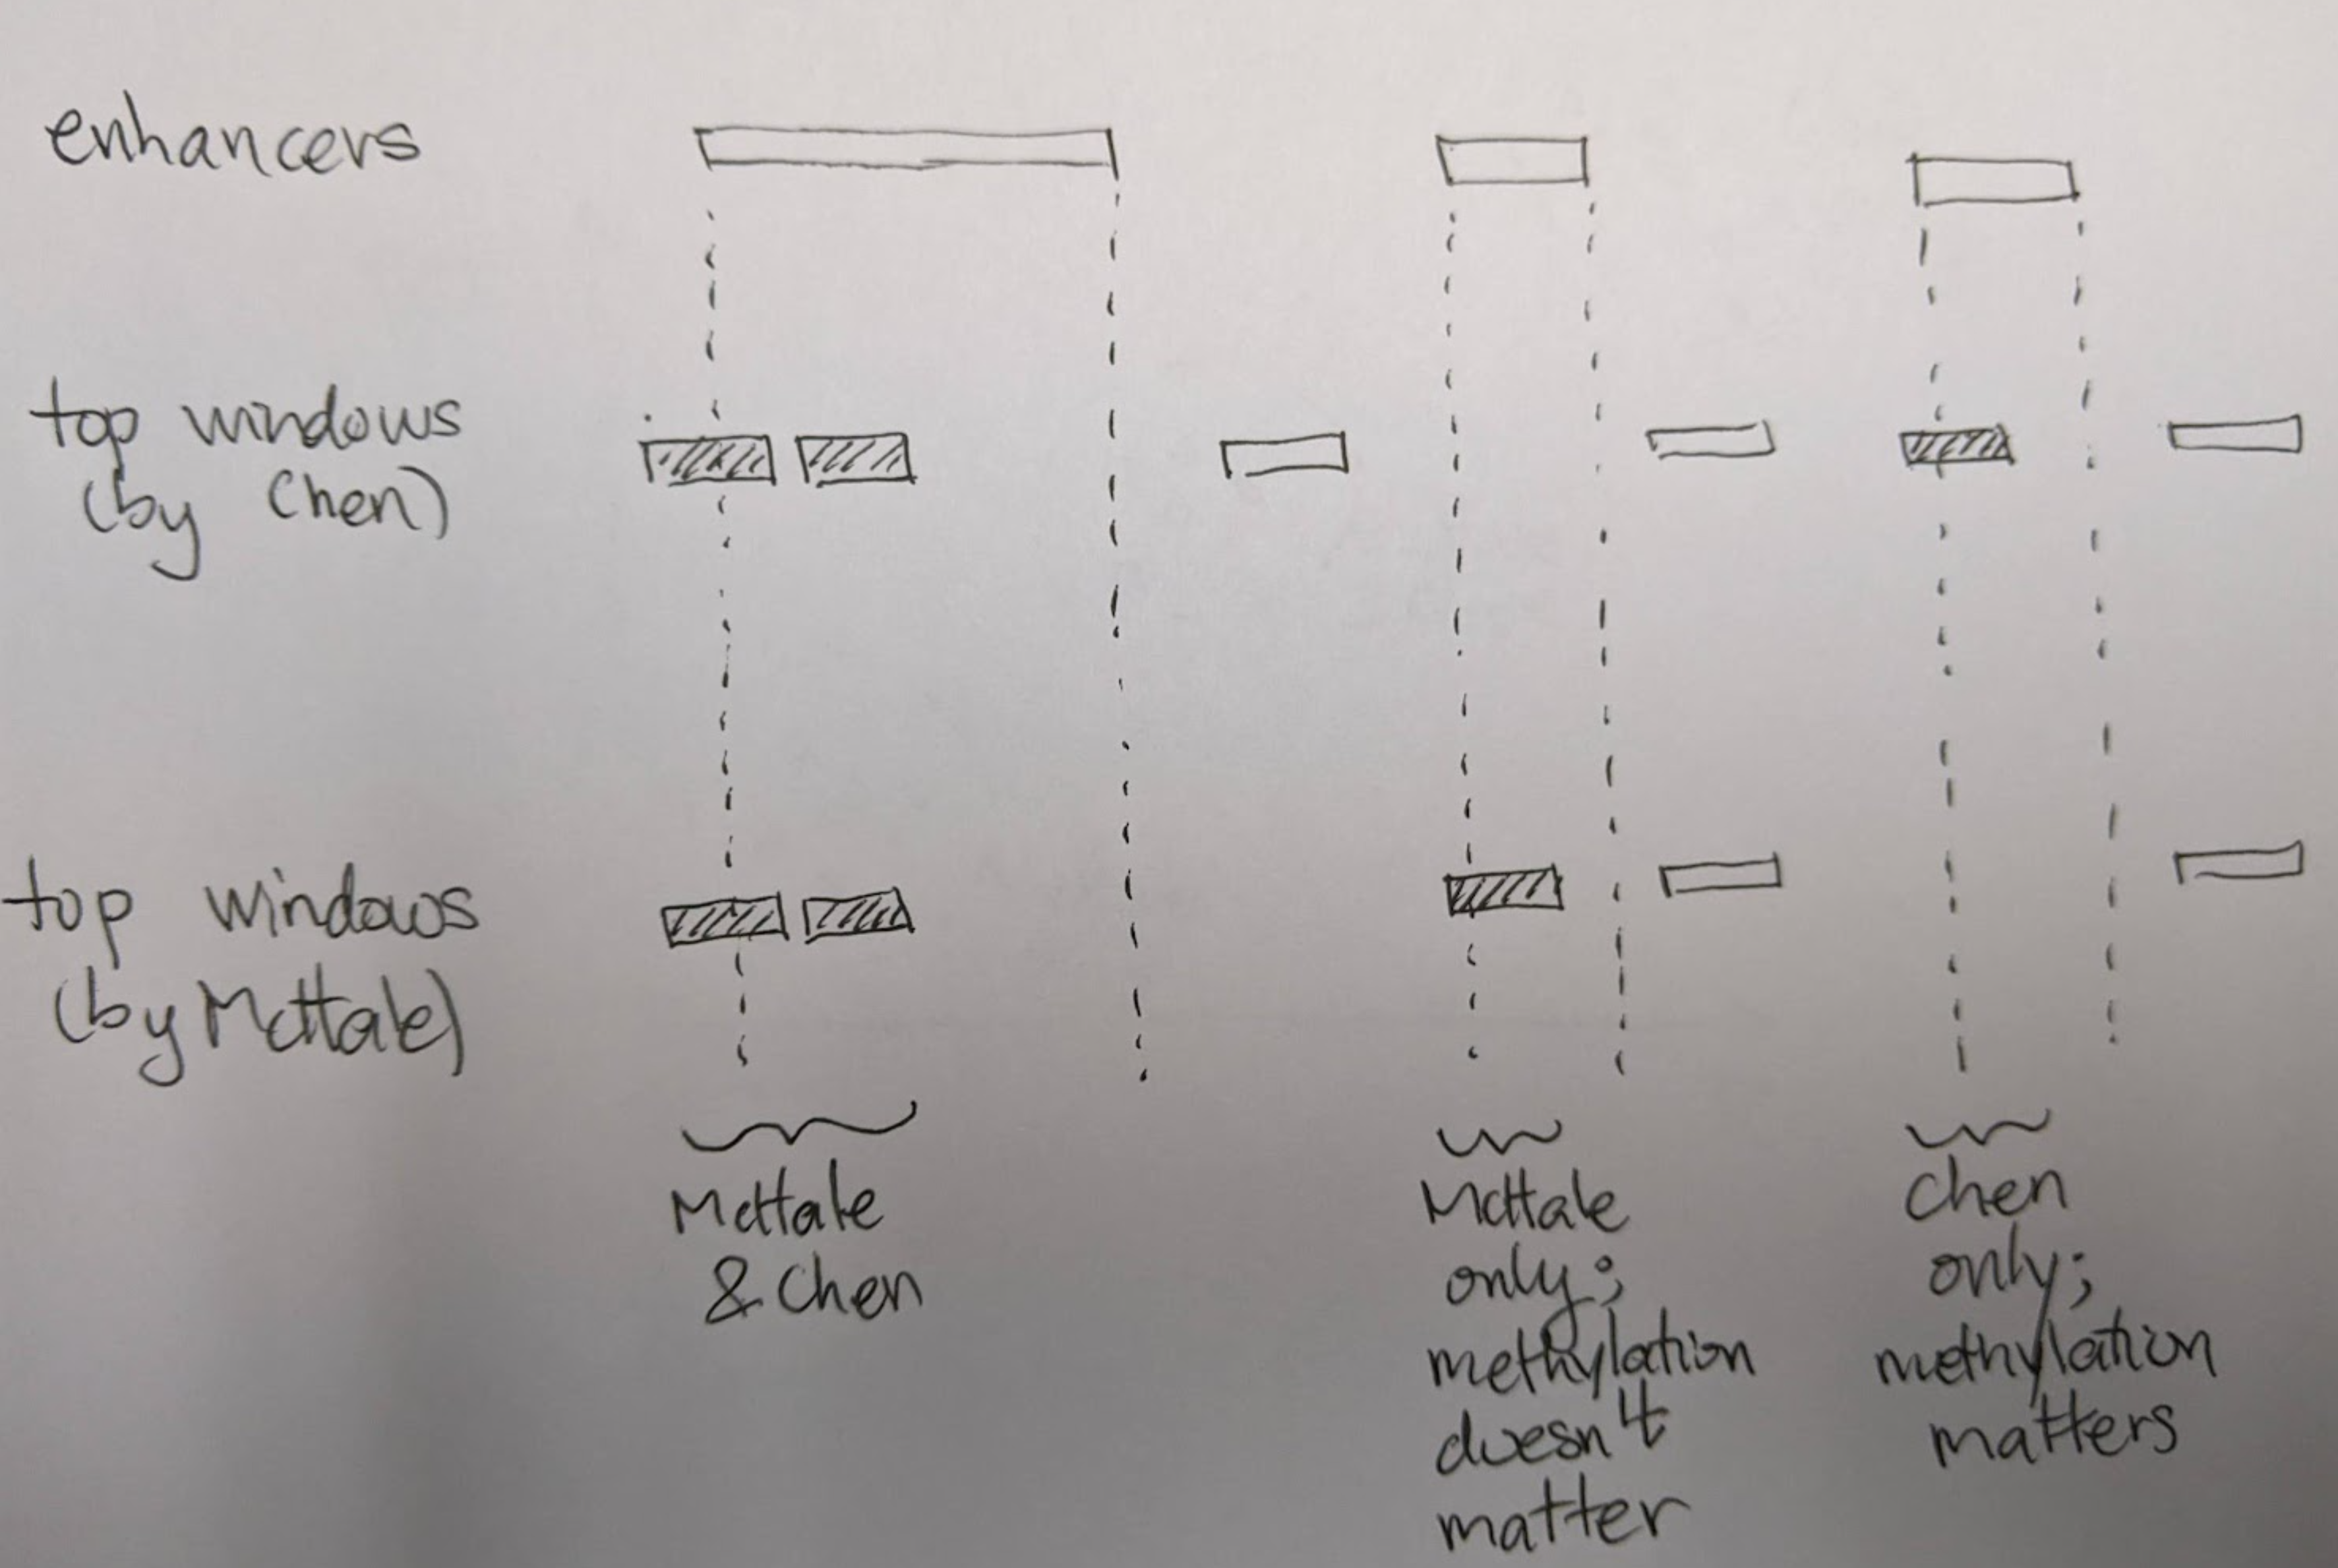

In [4]:
# embed raw image data in notebook: 
# https://github.com/microsoft/vscode-jupyter/issues/6437
from IPython.display import Image

Image(filename='windows-overlapping-enhancers.png', width=600)

In [5]:
def filter_df(
    feature_to_stratify_by,
    window_overlaps_stratify_feature
): 
    df = chen_mchale_enhancer_exon_replicationTiming
    df = df[
        (df[feature_to_stratify_by] == window_overlaps_stratify_feature) 
    ]
    return df


In [6]:
import warnings

def label_windows_with_quantiles(df, score, array_of_quantiles, quantile_labels): 
    df[f'{score} quantile'], bins = pd.qcut(
        df[score],
        q = array_of_quantiles, 
        labels = quantile_labels, 
        retbins = True,
#         duplicates='drop'
    )
    return df

def filter_and_label(
    feature_to_stratify_by,
    window_overlaps_stratify_feature,
    quantile,
    rank,
    feature_to_capture,
): 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        df = filter_df(
            feature_to_stratify_by,
            window_overlaps_stratify_feature,
        )

        array_of_quantiles = [0.0, quantile, 1.0]
        starts = array_of_quantiles[:-1]
        ends = array_of_quantiles[1:]
        quantile_labels = [f'{start} - {end}' for start, end in zip(starts, ends)]

        df = label_windows_with_quantiles(df, 'chen zscore', array_of_quantiles, quantile_labels)
        df = label_windows_with_quantiles(df, 'negative N_bar', array_of_quantiles, quantile_labels)

        quantile = quantile_labels[0] if rank == 'min' else quantile_labels[-1]

        df = df[
            (df['chen zscore quantile'] == quantile) | 
            (df['negative N_bar quantile'] == quantile)
        ]

        df = df[df[feature_to_capture] == True]

        def label_windows_with_set_membership(window):
            captured_by_chen = window['chen zscore quantile'] == quantile
            captured_by_mchale = window['negative N_bar quantile'] == quantile
            if captured_by_chen and captured_by_mchale: return 'Chen & McHale'
            if captured_by_chen and not captured_by_mchale: return 'Chen only' 
            if not captured_by_chen and captured_by_mchale: return 'McHale only'

        df[f'method for which window zscore is in {quantile} quantile'] = df.apply(
            label_windows_with_set_membership, 
            axis = 1
        )

        return df, quantile

# filter_and_label(
#     feature_to_stratify_by = 'window overlaps merged_exon',
#     window_overlaps_stratify_feature = True,
#     quantile = 0.995,
#     rank = 'max',
#     feature_to_capture = 'window overlaps enhancer',
# )[0]


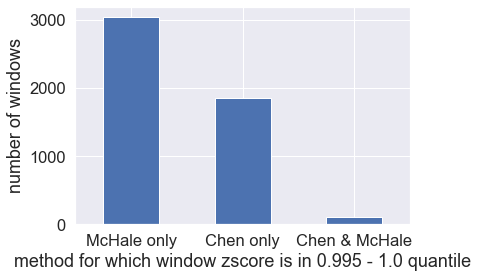

In [7]:
def plot_bar_chart(
    feature_to_stratify_by,
    window_overlaps_stratify_feature,
    quantile,
    rank,
    feature_to_capture,
):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        df, quantile = filter_and_label(
            feature_to_stratify_by,
            window_overlaps_stratify_feature,
            quantile,
            rank,
            feature_to_capture,
        )

        sns.set(font_scale=1.5)        
        ax = (
            df[f'method for which window zscore is in {quantile} quantile']
            .value_counts()
            .loc[['McHale only', 'Chen only', 'Chen & McHale']]
            .plot
            .bar()
        )

        plt.xlabel(f'method for which window zscore is in {quantile} quantile')
        plt.ylabel('number of windows')
        ax.tick_params(axis='x', rotation=0)
        plt.show()

plot_bar_chart(
    feature_to_stratify_by = 'window overlaps merged_exon',
    window_overlaps_stratify_feature = False,
    quantile = 0.995,
    rank = 'max',
    feature_to_capture = 'window overlaps enhancer',
)

## Replication timing distribution shifts to the right in the presence of enhancer/exon

Text(34.28307430555556, 0.5, 'number of windows')

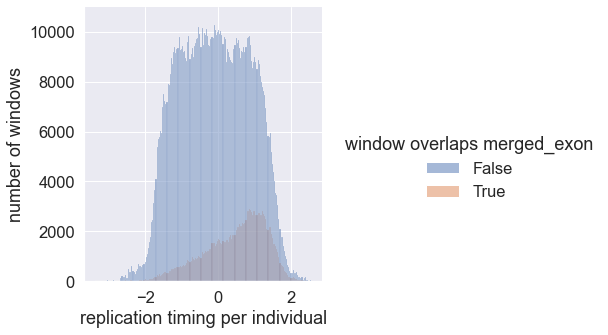

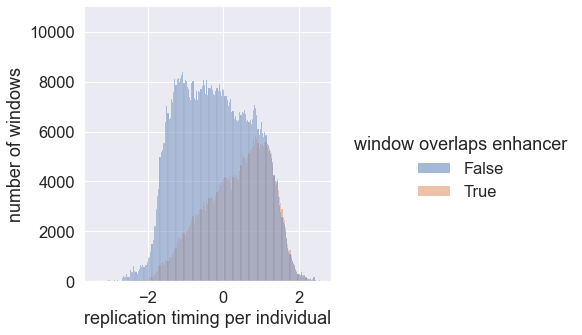

In [8]:
sns.displot(
    chen_mchale_enhancer_exon_replicationTiming, 
    x = "replication timing per individual", 
    hue = 'window overlaps merged_exon'
)
plt.ylim([0, 11000])
plt.ylabel('number of windows')

sns.displot(
    chen_mchale_enhancer_exon_replicationTiming, 
    x = "replication timing per individual", 
    hue = 'window overlaps enhancer'
)
plt.ylim([0, 11000])
plt.ylabel('number of windows')


## The replication-timing distribution of enhancer-containing windows that McHale picks up, and Chen doesn’t, is shifted to the right relative to that of windows that Chen picks up, and McHale doesn't

average scores for "McHale only" windows: neg. N_bar = 4.0375648271814395; Chen zscore = 1.3533043407552108
average scores for "Chen only" windows: neg. N_bar = 1.2877005280990323; Chen zscore = 4.22971914337049
average scores for "Chen & McHale" windows: neg. N_bar = 4.112017831683766; Chen zscore = 4.072571325709051


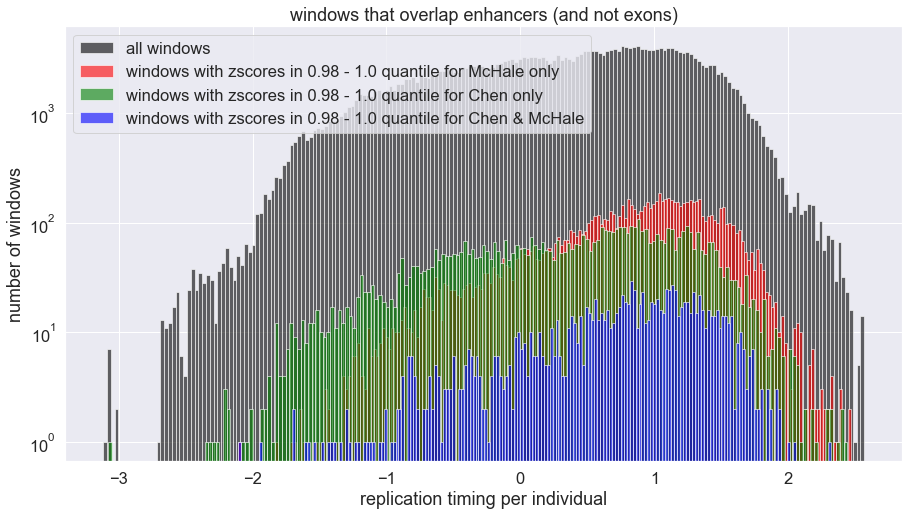

In [9]:
import numpy as np 

def plot_histogram_core(df, label, color): 
    plt.hist(
        df['replication timing per individual'], 
        bins = 200, 
        density = False, 
        facecolor = color, 
        alpha = 0.6, 
        label = label
    )
    
def plot_histogram_by_method(df, method, color, quantile): 
    df = df[df[f'method for which window zscore is in {quantile} quantile'] == method]
    print(f'average scores for "{method}" windows: neg. N_bar = {np.mean(df["negative N_bar"])}; Chen zscore = {np.mean(df["chen zscore"])}')
    plot_histogram_core(df, label=f'windows with zscores in {quantile} quantile for {method}', color=color)

def plot_histogram_background(
    feature_to_stratify_by,
    window_overlaps_stratify_feature,
    feature_to_capture
): 
    df = filter_df(
        feature_to_stratify_by,
        window_overlaps_stratify_feature,
    )
    df = df[df[feature_to_capture] == True]    
    plot_histogram_core(df, label='all windows', color='black')
    
def plot_histograms(window_overlaps_merged_exon, quantile): 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        feature_to_stratify_by = 'window overlaps merged_exon'
        feature_to_capture = 'window overlaps enhancer'
        
        plt.figure(figsize=(15, 8))    
        sns.set(font_scale=1.5)        

        plot_histogram_background(
            feature_to_stratify_by = feature_to_stratify_by,
            window_overlaps_stratify_feature = window_overlaps_merged_exon,
            feature_to_capture = feature_to_capture,
        )

        df, quantile = filter_and_label(
            feature_to_stratify_by = feature_to_stratify_by,
            window_overlaps_stratify_feature = window_overlaps_merged_exon,
            quantile = quantile,
            rank = 'max',
            feature_to_capture = feature_to_capture,
        )

        plot_histogram_by_method(df, 'McHale only', 'red', quantile)
        plot_histogram_by_method(df, 'Chen only', 'green', quantile)
        plot_histogram_by_method(df, 'Chen & McHale', 'blue', quantile)
        plt.yscale('log')
        plt.title(f'windows that overlap enhancers (and{"" if window_overlaps_merged_exon else " not"} exons)')
        plt.xlabel('replication timing per individual')
        plt.ylabel('number of windows')
        plt.legend()
    
plot_histograms(
    window_overlaps_merged_exon = False,
    quantile = 0.980
)

## McHale outperforms Chen because negative N_bar does a better job of enriching for high-replication-timing scores, where enhancers are concentrated  



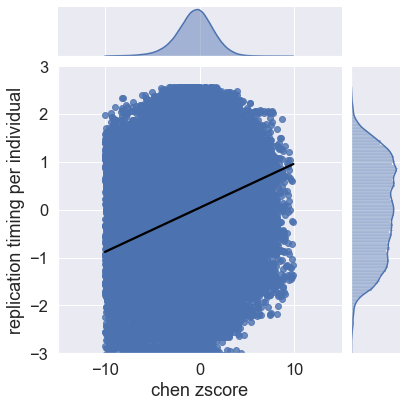

In [10]:
sns.jointplot(
    x = "chen zscore", 
    y = "replication timing per individual", 
    data = chen_mchale_enhancer_exon_replicationTiming,
    kind = "reg",
    line_kws = {"color": "black"},       
    ci = None,
    xlim = (-15,15), 
    ylim = (-3,3)
)

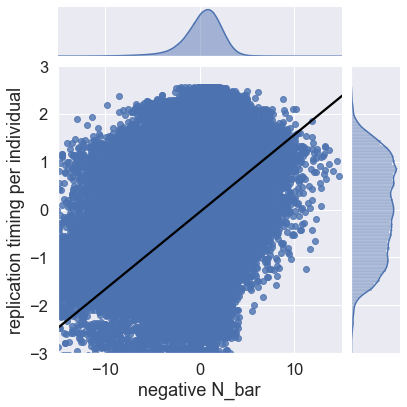

In [11]:
sns.jointplot(
    x = "negative N_bar", 
    y = "replication timing per individual", 
    data = chen_mchale_enhancer_exon_replicationTiming,
    kind = "reg",
    line_kws = {"color": "black"},       
    ci = None,
    xlim = (-15,15), 
    ylim = (-3,3)
)

This also explains the trends observed in the histograms from the previous section, 
namely why the "McHale-only" class 
(which has high `negative N_bar`) 
has high replication-timing scores, 
while the "Chen-only" class (which, by definition, has low `negative N_bar`) 
has low replication timing scores! 

## Incorporating replication timing may reduce sensitivity to detect enhancers

Chen's model regresses SNV count against replication timing. (Note: only the regression line, and not the scatter about the regression line, is used to adjust Chen's expectation about SNV count per window.) The plot below 
shows that Chen expects fewer SNVs for windows with larger replication timing scores. In contrast, 
McHale would expect the same number of SNVs, irrespective of replication timing scores. 
This would lead to Chen throwing out more windows with high replication-timing scores than McHale, 
yet many enhancers have high replication timing scores, and high SNV count per window! 

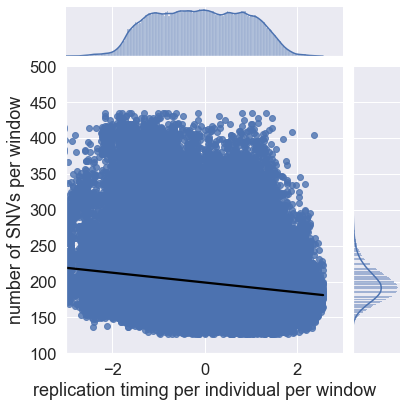

In [12]:
def plot_SNVs_against_replicationTiming(restrict_to_enhancers): 
    df = chen_mchale_enhancer_exon_replicationTiming.copy()
    df = df[
        (df['window overlaps merged_exon'] == False)
    ]
    if restrict_to_enhancers: 
        df = df[
            (df['window overlaps enhancer'] == True)
        ]
    h = sns.jointplot(
        x = "replication timing per individual", 
        y = "M", 
        data = df,
        kind = "reg",
        line_kws = {"color": "black"},       
        ci = None,
        xlim = (-3,3), 
        ylim = (100,500)        
    )
    
    h.ax_joint.set_xlabel('replication timing per individual per window')
    h.ax_joint.set_ylabel('number of SNVs per window')
      
plot_SNVs_against_replicationTiming(restrict_to_enhancers=False)

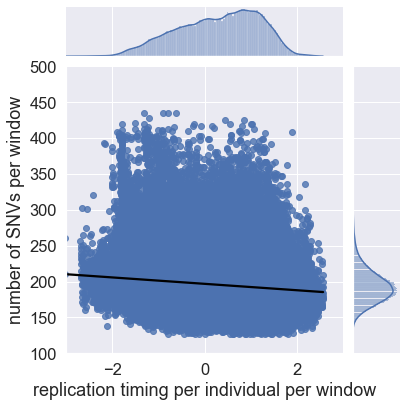

In [13]:
plot_SNVs_against_replicationTiming(restrict_to_enhancers=True)